In [2]:
from __future__ import print_function
%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [3]:
# Set random seed for reproducibility
manualSeed = 997
# manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  997


In [4]:
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 128

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 1

# Learning rate for optimizers
lr_dis = 0.00005
lr_gen = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 0



device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
fixed_noise = torch.randn(64,nz,1,1,device=device)

In [5]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 128 x 128
            nn.Conv2d(nc, ndf, 4, stride=2, padding=1, bias=False),
            nn.SELU(inplace=True),
#               nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 64 x 64
            nn.Conv2d(ndf, ndf * 2, 4, stride=2, padding=1, bias=False),
            nn.SELU(inplace=True),
#               nn.BatchNorm2d(ndf * 2),
#               nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 32 x 32
            nn.Conv2d(ndf * 2, ndf * 4, 4, stride=2, padding=1, bias=False),
            nn.SELU(inplace=True),
#               nn.BatchNorm2d(ndf * 4),
#               nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 16 x 16 
            nn.Conv2d(ndf * 4, ndf * 8, 4, stride=2, padding=1, bias=False),
            nn.SELU(inplace=True),
#               nn.BatchNorm2d(ndf * 8),
#               nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 8 x 8
            nn.Conv2d(ndf * 8, ndf * 16, 4, stride=2, padding=1, bias=False),
            nn.SELU(inplace=True),
#               nn.BatchNorm2d(ndf * 16),
#               nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*16) x 4 x 4
            nn.Conv2d(ndf * 16, 1, 4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
            # state size. 1
        )

    def forward(self, input):
        return self.main(input)

      # Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     nz, ngf * 16, 4, 1, 0, bias=False),
            nn.SELU(inplace=True),
#               nn.BatchNorm2d(ngf * 16),
#               nn.ReLU(True),
            # state size. (ngf*16) x 4 x 4
            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.SELU(inplace=True),
#               nn.BatchNorm2d(ngf * 8),
#               nn.ReLU(True),
            # state size. (ngf*8) x 8 x 8
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.SELU(inplace=True),
#               nn.BatchNorm2d(ngf * 4),
#               nn.ReLU(True),
            # state size. (ngf*4) x 16 x 16 
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.SELU(inplace=True),
#               nn.BatchNorm2d(ngf * 2),
#               nn.ReLU(True),
            # state size. (ngf*2) x 32 x 32
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.SELU(inplace=True),
#               nn.BatchNorm2d(ngf),
#               nn.ReLU(True),
            # state size. (ngf) x 64 x 64
            nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 128 x 128
        )

    def forward(self, input):
        return self.main(input)

In [6]:
netG = Generator(ngpu).to(device)
netD = Discriminator(ngpu).to(device)
optimizerD = optim.Adam(netD.parameters(), lr=lr_dis, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr_gen, betas=(0.5, 0.999))

checkpoint = torch.load("./128_CarGan_epoch170.tar", map_location='cpu')
netG.load_state_dict(checkpoint['netG_state_dict'])
netD.load_state_dict(checkpoint['netD_state_dict'])
optimizerD.load_state_dict(checkpoint['optimizerD_state_dict'])
optimizerG.load_state_dict(checkpoint['optimizerG_state_dict'])

netG.eval()
netD.eval()

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): SELU(inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): SELU(inplace)
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): SELU(inplace)
    (6): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): SELU(inplace)
    (8): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): SELU(inplace)
    (10): Conv2d(1024, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (11): Sigmoid()
  )
)

In [ ]:
img_list = []
good_results = [0,1,2,3,4,5,6,7,8,14,15,16,17,18,19,24,26,29,40,41,42,43,46,47,49,50,54,55,57,58,60,61,62]

with torch.no_grad():
    fake = netG(fixed_noise).detach().cpu()
    img_list.append(vutils.make_grid(fake, padding = 2, normalize = True))
    for i in good_results:
        vutils.save_image(fake[i], './generated/' + str(i) + '.jpg', normalize = True)
        
fig = plt.figure(figsize = (12,12))  
  
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=False)] for i in img_list]

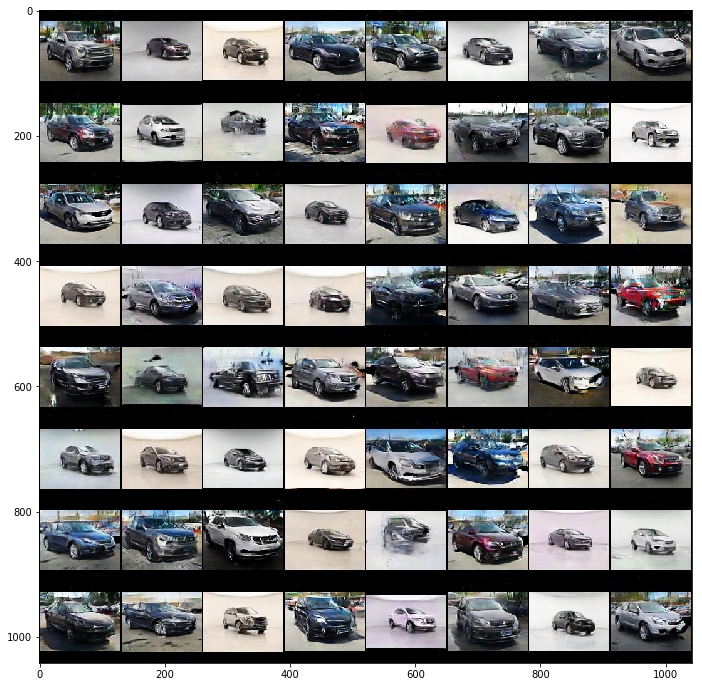

In [8]:
new_img_list = []
with torch.no_grad():
    fake = netG(fixed_noise).detach().cpu()
    new_img_list.append(vutils.make_grid(fake, padding = 2, normalize = True))
        
fig = plt.figure(figsize = (12,12))  
  
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=False)] for i in new_img_list]

In [12]:
import glob

In [39]:
files_0 =  glob.glob("./generated/997_seed/*.jpg")
files_1 =  glob.glob("./generated/998_seed/*.jpg")
files_2 =  glob.glob("./generated/999_seed/*.jpg")
files = files_0 + files_1 + files_2

In [45]:
len(files)
random.shuffle(files)

64


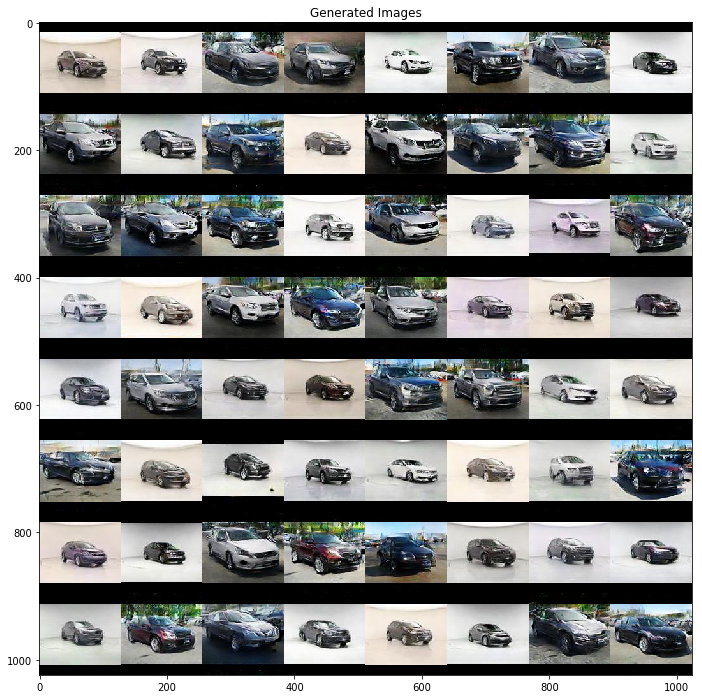

In [49]:
def gallery(array, ncols=8):
    nindex, height, width, intensity = array.shape
    nrows = nindex//ncols
    assert nindex == nrows*ncols
    # want result.shape = (height*nrows, width*ncols, intensity)
    result = (array.reshape(nrows, ncols, height, width, intensity)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols, intensity))
    return result

def make_array():
    from PIL import Image
    my_array = []
    for i in range(64):
        my_array.append(np.asarray(Image.open(files[i]).convert('RGB')))
    print(len(my_array))
    return np.array(my_array)

array = make_array()
result = gallery(array)
fig = plt.figure(figsize = (12,12))
plt.imshow(result)
plt.title('Generated Images')
plt.show()